# Fitting is an Art!

## Description
Python macro for fitting (possible) peaks (typically signal) on top of a distribution (typically background). It is also an exercise in making ChiSquare and likelihood fits work, and get a feel for which fitting proceedure is likely to give good results.

This program contains most the necessary code for fitting with a ChiSquare. The case has been chosen carefully, and should illustrate several points. Please, _play around_ with it as much as you can.


## Your Task

This exercise is meant to improve your understanding of but also your experience with
ChiSquare and Likelihood fits. The below are indicative questions, but you should
also "play around" yourself to see, if you understand how the three behave, when you
change conditions.

---

### Authors
- Troels Petersen ([email](mailto:petersen@nbi.dk))
- Étienne Bourbeau (notebook conversion) ([email](mailto:etienne.bourbeau@icecube.wisc.edu))

### Date
25th of November 2020

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from iminuit import Minuit
from scipy import stats
import os, sys                                         # Modules to see files and folders in directories
from os.path import dirname as parent_folder
# plt.close('all')

In [2]:
sys.path.append('../../../External_Functions')
from ExternalFunctions import Chi2Regression, BinnedLH, UnbinnedLH
from ExternalFunctions import nice_string_output, add_text_to_ax    # Useful functions to print fit results on figure

Ignore LogWarning (Python may complain, if it takes the log of too small numbers, e.g. log-likelihood):

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
r = np.random             # Random generator
r.seed(42)                # Set a random (but fixed) seed

font_size = 10

In [5]:
Verbose = False
Saveplots = False

These are switches to decide, if signal should be included in the data, and also fitted for:

In [6]:
IncludeSignalInData = True
IncludeSignalInFit = True

One may want to assert, that one is not fitting for a signal, that is not there!

However, in reality this is often what we actually do, to assert what the largest deviation from background is.

This type of "bump hunting" can be challeging, and very common in many sciences.

In [7]:
# assert not ((IncludeSignalInData == False) and (IncludeSignalInFit == True))

---
## CASE: Gaussian distribution on an exponential background:
 * $signal(x) = \frac{N_{sig}}{\sigma \sqrt{2\pi}} \cdot \exp{\left [-0.5 \cdot (\frac{x-\mu}{\sigma})^{2}\right]}$ for $x$ in [0,200]
 
 * $bkg(x) = N_{bkg} \cdot  c \cdot \exp{[-cx]}$                   for $x$ in [0,200]
---

In [8]:
# Produce signal (Gaussian peak):
Nsigx  =  20
mux    = 125.0
# mux    = r.uniform(10.0, 190.0)    # For signal peak of unknown position
mux_init = mux                       # Initial value to use for the peak position in fit
sigmax =   3.0

if IncludeSignalInData:
    x_signal = r.normal(mux, sigmax, Nsigx)
    if (Verbose) :
        print("  Signal: ", x_signal)
else:
    x_signal = []

In [9]:
# Produce background (here exponential):
Nbkgx =  500
taux  =   80.0    # "Lifetime" of background
x_background = r.exponential(taux, Nbkgx)
if (Verbose) :
    print("  Background: ", x_background)

In [10]:
# Histogram specifications:
xmin =   0.0
xmax = 200.0
Nbins =  100       # Note that this gives the bins a natural width, and is much smaller than sigma of the signal!
binwidth = (xmax-xmin) / Nbins

In [11]:
# Note: The x_signal and x_background needs to be in a parenthesis inside the other
# parenthesis, because of the posibility of several other options.
x_data = np.concatenate((x_signal, x_background))    # Combine the two numpy arrays
if (Verbose) :
    print("  Data: ", x_data)

---
Define PDFs:
---

In [12]:
# Normalized Gaussian:
def gauss_pdf(x, mu, sigma):
    # return np.exp(-(x - mu)**2 / 2.0 / sigma**2)
    return 1.0 / np.sqrt(2 * np.pi) / np.abs(sigma) * np.exp(-(x - mu)**2 / 2.0 / sigma**2)

In [13]:
# Normalized Exponential:
def exponential_pdf(x, tau):
    # return np.exp(-x/tau)
    return 1.0 / tau * np.exp(-x/tau)

Next we write up the full model PDF (one for ChiSquare [CS], one for Binned Likelihood [BL], and
one for unbinned likelihood [UL]). They are identical, except for the normalisation, where the ChiSquare includes the bin width.

We make two versions, one which is a background fit only, and the other which includes the signal PDF in the fit function.

In [14]:
if IncludeSignalInFit:
    def PDFmodel_CS(x, Nsig, mu, sigma, Nbkg, tau) :
        return Nbkg * binwidth * exponential_pdf(x, tau) + Nsig * binwidth * gauss_pdf(x, mu, sigma)
        #solution:
    def PDFmodel_BL(x, Nsig, mu, sigma, Nbkg, tau) :
        return Nbkg * exponential_pdf(x, tau) + Nsig * gauss_pdf(x, mu, sigma)
    
    def PDFmodel_UL(x, Nsig, mu, sigma, Nbkg, tau) :
        return Nbkg * exponential_pdf(x, tau) + Nsig * gauss_pdf(x, mu, sigma)
    
else:
    def PDFmodel_CS(x, Nbkg, tau) :
        return Nbkg * binwidth * exponential_pdf(x, tau) 
        #solution:
    def PDFmodel_BL(x, Nbkg, tau) :
        return Nbkg * exponential_pdf(x, tau)
    
    def PDFmodel_UL(x, Nbkg, tau) :
        return Nbkg * exponential_pdf(x, tau) 
    

---
Plot the data:
---

The data from the histogram is here plotted with error bars:

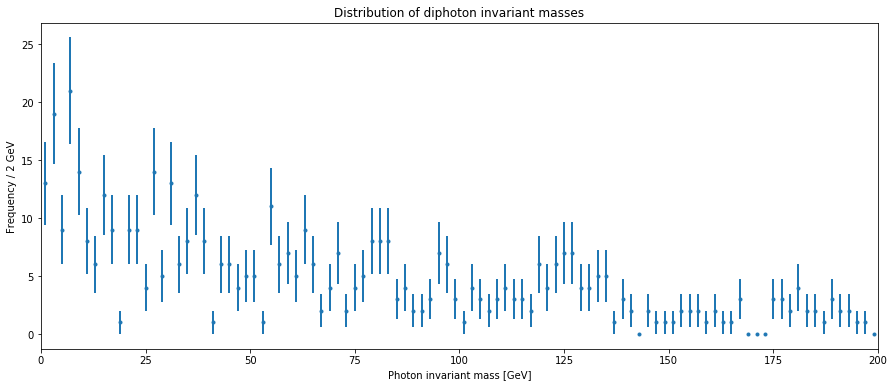

In [15]:
fig, ax = plt.subplots(figsize=(15, 6))
# For a normal histogram (without error bars shown) one would use:
# hist_data = ax.hist(x_data, bins=Nbins, range=(xmin, xmax), histtype='step', linewidth=2, label='Data', color='blue')
y, bin_edges = np.histogram(x_data, bins=Nbins, range=(xmin, xmax), normed=False)
x = 0.5*(bin_edges[1:] + bin_edges[:-1])
sy = np.sqrt(y)      # This is the standard for histograms - each bin is Poisson distributed!
hist_data = ax.errorbar(x, y, sy, fmt='.', linewidth=2, label="Data")
ax.set(xlabel="Photon invariant mass [GeV]", ylabel = "Frequency / {0:1.0f} GeV".format(binwidth),
       title = "Distribution of diphoton invariant masses", xlim=(xmin, xmax))
fig;

---
Fit the data:
---

NOTE, that for the starting values for the fit, we here (to begin with) use the values that the data was generated with!
That is of course a great advantage, and one of the main challenges in general fitting is to find these good starting values.

## $\chi^{2}$, binned Likelihood, or unbinned likelihood fit:
Do the fit with a Chi2 minimisation (only using bins with entries):

In [16]:
#solution:uncomment the desired type of fit
type_of_fit='unbinned_LH' #set to 'chi2reg' or 'binned_LH' or 'unbinned_LH'
if type_of_fit=='chi2reg':
    fit_object = Chi2Regression(PDFmodel_CS, x[y>0], y[y>0], sy[y>0])
elif type_of_fit=='binned_LH':
    fit_object = BinnedLH(PDFmodel_BL, x_data, bins=Nbins, bound=(xmin, xmax), extended=True)
elif type_of_fit=='unbinned_LH':
    fit_object = UnbinnedLH(PDFmodel_UL, x_data, extended=True)


if IncludeSignalInFit:
    minuit_obj = Minuit(fit_object, pedantic=False, print_level=0, Nsig=Nsigx, mu=mux_init, sigma=sigmax, Nbkg=Nbkgx, tau=taux)
else:
    minuit_obj = Minuit(fit_object, pedantic=False, print_level=0, Nbkg=Nbkgx, tau=taux)
minuit_obj.migrad()                                                         # Perform the actual fit
if (not minuit_obj.get_fmin().is_valid) :                                   # Check if the fit converged
    print("  WARNING: The ChiSquare fit DID NOT converge!!!")

In [17]:
minuit_output = [minuit_obj.get_fmin(), minuit_obj.get_param_states()]       # Save the output parameters in case needed
if IncludeSignalInFit:
    csfit_Nsig, csfit_mu, csfit_sigma, csfit_Nbkg, csfit_tau = minuit_obj.args  # The fitted values of the parameters
else:
    csfit_Nbkg, csfit_tau = minuit_obj.args
if type_of_fit=='chi2reg':
    Chi2_value_cs = minuit_obj.fval                                             # The Chi2 value
    NvarModel_cs = len(minuit_obj.args)
    Ndof_cs = len(y[y>0]) - NvarModel_cs
    ProbChi2_cs = stats.chi2.sf(Chi2_value_cs, Ndof_cs)
else:
    Chi2_value_cs = minuit_obj.fval # it's actually the likelihood!!
    NvarModel_cs = np.nan
    Ndof_cs = 0
    ProbChi2_cs = np.nan
    
for name in minuit_obj.parameters:
    print("Fit result: {0} = {1:.5f} +/- {2:.5f}".format(name, minuit_obj.values[name], minuit_obj.errors[name]))

Fit result: Nsig = 23.44306 +/- 7.62965
Fit result: mu = 126.46751 +/- 1.82507
Fit result: sigma = 4.87626 +/- 1.42915
Fit result: Nbkg = 503.86410 +/- 23.45370
Fit result: tau = 85.59382 +/- 4.38380


Plotting the result on top of the previously plotted data:
---

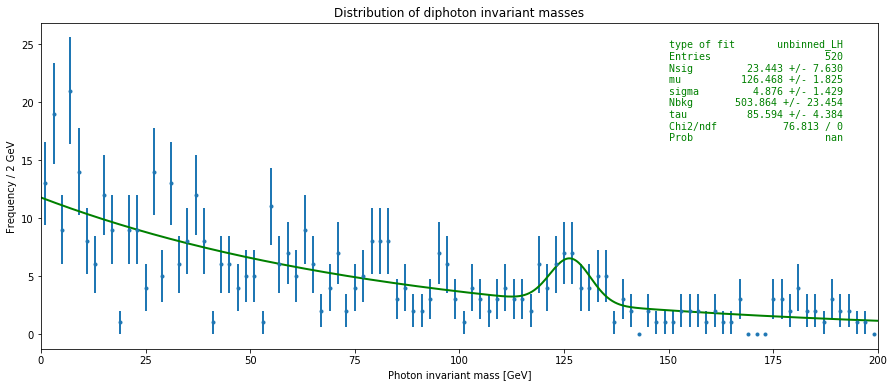

In [18]:
x_csfit = np.linspace(xmin, xmax, 1000)      # Create the x-axis for the plot of the fitted function

if IncludeSignalInFit:
    y_csfit = PDFmodel_CS(x_csfit, csfit_Nsig, csfit_mu, csfit_sigma, csfit_Nbkg, csfit_tau)
else:
    y_csfit = PDFmodel_CS(x_csfit, csfit_Nbkg, csfit_tau)


# Adding in some text (useful histogram and fit information) around the plot before showing it:
if IncludeSignalInFit:
    names = ['type of fit', 'Entries', 'Nsig', 'mu', 'sigma', 'Nbkg', 'tau', 'Chi2/ndf', 'Prob']
    values = [type_of_fit,
              "{:d}".format(len(x_data)),
              "{:.3f} +/- {:.3f}".format(minuit_obj.values['Nsig'], minuit_obj.errors['Nsig']),
              "{:.3f} +/- {:.3f}".format(minuit_obj.values['mu'], minuit_obj.errors['mu']),
              "{:.3f} +/- {:.3f}".format(minuit_obj.values['sigma'], minuit_obj.errors['sigma']),
              "{:.3f} +/- {:.3f}".format(minuit_obj.values['Nbkg'], minuit_obj.errors['Nbkg']),
              "{:.3f} +/- {:.3f}".format(minuit_obj.values['tau'], minuit_obj.errors['tau']),
              "{:.3f} / {:d}".format(Chi2_value_cs, Ndof_cs),
              "{:.3f}".format(ProbChi2_cs),
              ]
else:
    names = ['type of fit','Entries', 'Nbkg', 'tau', 'Chi2/ndf', 'Prob']
    values = [type_of_fit,
              "{:d}".format(len(x_data)),
              "{:.3f} +/- {:.3f}".format(minuit_obj.values['Nbkg'], minuit_obj.errors['Nbkg']),
              "{:.3f} +/- {:.3f}".format(minuit_obj.values['tau'], minuit_obj.errors['tau']),
              "{:.3f} / {:d}".format(Chi2_value_cs, Ndof_cs),
              "{:.3f}".format(ProbChi2_cs),
              ]
    
d={}
for n,v in zip(names,values):
    d[n]=v
    
if type_of_fit=='chi2reg':
        ax.plot(x_csfit, y_csfit, '-', color='red', linewidth=2, label='ChiSquare fit')
        ax.text(0.15, 0.95, nice_string_output(d, 0), family='monospace',
                transform=ax.transAxes, fontsize=font_size, color='red', verticalalignment='top') 
elif type_of_fit=='binned_LH':
        ax.plot(x_csfit, y_csfit, '-', color='blue', linewidth=2, label='binned_LH fit')
        ax.text(0.4, 0.95, nice_string_output(d, 0), family='monospace',
                transform=ax.transAxes, fontsize=font_size, color='blue', verticalalignment='top') 
elif type_of_fit=='unbinned_LH':
        ax.plot(x_csfit, y_csfit, '-', color='green', linewidth=2, label='unbinned_LH fit')
        ax.text(0.75, 0.95, nice_string_output(d, 0), family='monospace',
                transform=ax.transAxes, fontsize=font_size, color='green', verticalalignment='top') 
else:
        type_of_fit='unknown type of fit'
        ax.plot(x_csfit, y_csfit, '-', color='black', linewidth=2, label='unknown type of fit')
        ax.text(0.4, 0.95, nice_string_output(d, 0), family='monospace',
                transform=ax.transAxes, fontsize=font_size, color='black', verticalalignment='top') 

        
fig       # This prints plots the figure

## Plot everything together: 


---

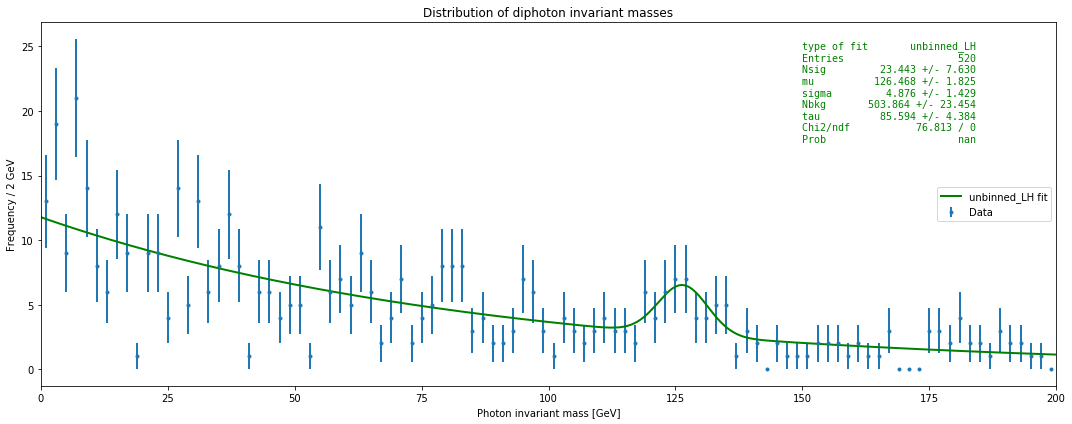

In [21]:
fig.tight_layout()
ax.legend(loc='center right')
fig

In [20]:
if Saveplots:
    fig.savefig("ExampleLikelihoodFit", dpi=600)

Questions:
---
 0. Given the data (first without signal), see if you can write a ChiSquare fit to match it.
    Remember to give the fit good starting values. Alternatively, consider the ChiSquare fit
    that is provided.
    Can you also write an unbinned likelihood fit? Remember, that contrary to the ChiSquare fit,
    this should not include the binwidth in the normalisation of the PDF. And if you feel on top
    of things, then perhaps a binned one?
    
 _Example solution 0_:
 The code above provides solutions. As there is ample data, the ChiSquare fit is perfectly good, and should be preferred over the likelihood fits. 

---

 1. Run the program without a signal peak and high statistics. Are the two/three fit
    results similar, and was that what you would expect? And is the model (i.e. PDF) good?
    Think about how you _quantify_ if the model is good, and how you determine if the fitting
    method is valid.
     
 _Example solution 1_:
 The fits should be very similar, as the bins contain way more than 20 entries each, and thus the Gaussian approximation of the Poisson in each bin (used by the ChiSquare) should  be very good. Given the high p-value of the ChiSquare fit, the model is representative of the data -- i.e. the H0 hypothesis holds. It is only the ChiSquare, that can actually test this, but since the other models use the same PDF, they are also good.

---

 2. Now lower the number of background events from 25000 to 500 and ask yourself the above
    questions.
 
 _Example solution 2_:
 The models (i.e. PDFs) are still good, as this is the same data, just much lower statistics. In this case the ChiSquare does not provide a good fit, which is evident both from the low p-value and the clear underestimation of the background. Here, the likelihood fits are much better at estimating the background. 

---

 3. Switch on the signal of 50 events, both in the data and in the fit(s). How confident are
    you, that you can see the signal in the data? Lower the number of signal events, until the
    point where you are no longer certain, that you can see a peak by eye. Then consider the
    significance (i.e. the number of sigma's) of Nsig. Does the size of this correspond well
    with your observation?

 _Example solution 3_:
 The significance is immediately read off the fit as $N_{sig} / \sigma(N_{sig})$, i.e. how many standard deviations is the amplitude of the signal away from zero. As the ChiSquare is only approximately trustworthy, consider the unbinned likelihood, and calculate 51.8 / 9.6 = 5.4 sigma. Thus, the peak is in this case very certain, as it is greater than 5 sigma (called an "observation").
 
 To test the hypothesis that there is a signal, one could calculate the likelihood ratio between fitting with and without the gaussian. For the background only hypothesis (H0-null hypothesis) we get a likelihood value of $-2*log(LLH) = 88.52$, while for peak hypothesis (H1-alternative) we get $-2*log(LLH) = 50.16$. This yields a ratio of $D = -2 log(LLH_{H0} / LLH_{H1}) = 88.52 - 50.16 = 38.36$. There are 6-3=3 degrees of freedom between the two hypotheses (calculated from the number of parameters in the fits), which yields a p-value for the null hypothesis of Prob(38.36, 3) = $2.3 \times 10^{-8}$. There is thus no chance in hell, that this was a random fluctuation of the background!
 
 Lowering the number of signal events to around 12-15, I start doubting that there is a peak, when just looking at the data (i.e. don't let you be (potentially mis-) guided by the fits). The significance is then 2-2.5 sigma, which one would probably expect some random peak to have in this sample -- i.e. it's just random noise.

---

 4. Try to set the number of signal events to 20, but choose a random location of the signal
    peak (mux) and set the initial value to say 125, i.e. pretending that you don't know, if or
    where there is a peak.
    See if the fit can find the position of the signal peak and hence converge correctly.
 
 _Example solution 4_: The fits now all converges on a much smaller (i.e. less significant) peak around 125 instead of finding the "correct" peak (in my case around 76). This simply goes to show, that the fit is incapable of searching for peaks without assistance (from you!).

---

 5. Also try to remove the signal from data, and see if the fit (including signal) still "finds"
    any peaks. This is the pitfall of searching for peaks, that may very well not be there!!!
 
 _Example solution 5_: The fits will now do "anything", as it is given enough degrees of freedom to fit for something, that isn't there! In my case, the ChiSquare finds a small peak next close to 125 GeV, the binned likelihood finds a larger - negative!- peak below 125 GeV, and the unbinned likelihood does not even converge. Conclusion: Searching for peaks that might not be there is hard!

---

 6. Given 500 background and 20 signal events, ask yourself what helps the most to discover
    a signal peak:
    
     - Removing half the background below the peak.
     - Improving the resolution (sigma) by a factor two.
     
    Discuss first what you think (and why) with those around you, and then try it out with this fit.
    
 _Example solution 6:_ The significance $K$ of a peak with $S$ signal events and $B$ background events under is roughly given by $K = S \ \sqrt{S+B}$. In this case, improving the signal resolution by a factor two (from 3.0 to 1.5) would yield the same number of signal events within half the range, and thus correspond to having half the number of background events. The two should therefore roughly have the same effect.
 
---

Advanced questions:
---
 0. In general, how far can the initial parameter values stray from the true ones,
    and still find the correct signal peak and hence true minimum of the Chi2/LLH?
    Note here, that also the width and the normalisation are generally unknown in real data!

 1. Make a loop to repeat the fits many times, and see how the result of the
    fit compares to the true values. Which fit is least biased? And does this depend
    on the value of the input parameters?

 2. The likelihood value does not in itself tell you much. But if repeated many times
    (as above) it can be used to evaluate the fit at hand. Try to produce new data and
    fit it 1000 times, and see the distribution of likelihood values obtained... and
    then compare the "original data LLH value" with this distribution! From this, one
    can actually obtain a probability for the LLH in the same way as for the ChiSquare.
